# Parallelizing scientific experiments

In this blog post, I want to show my approach to parallelize scientific experiments using Python multiprocessing. While there may be other (better) methods to do this, the procedure described here has proven to be effective for me. We will evaluate Decision Trees and Random Forests on the Arrhythmia and Wisconsin Breast Cancer datasets.

In a nutshell, evaluating machine learning algorithms typically requires
1. comparing ones own algorithm to the state of the art.
2. repeating an experiment multiple times to obtain reliable results.

The most inefficient way to do this is to loop over all algorithms, data sets, and experiment repetitions or folds. A more efficient method is to parallelize one of the loops. However, this still leaves us with a substantial amount of sequential processing. The most efficient solution lies in allowing the system to concurrently execute all algorithm-dataset-fold combinations in parallel.

## Setting up algorithm and dataset dictionaries:

To begin, we need to set up two dictionaries that contain the algorithms and data sets we wish to utilize for our evaluation. For this purpose, we will retrieve the datasets from openml, a popular platform for sharing machine learning datasets.

In [1]:
import copy
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml

def load_dataset_with_id(id):
    ds = fetch_openml(data_id=id)
    # For this example we simply get rid of attributes that contain nans.
    # Note that this is, in general, not best practice!
    data = ds.data.dropna(axis=1)
    target = ds.target
    return data, target

algs = {"Decision Tree": DecisionTreeClassifier(random_state=0),
        "Random Forest": RandomForestClassifier(random_state=0)}

datasets = {
    "Arrhythmia": load_dataset_with_id(5),
    "Wisconsin Breast Cancer": load_dataset_with_id(1510),
}

We also define some macros for the columns of the data frame that will contain the experiment results:

In [2]:
ALGORITHM = "Algorithm"
DATASET = "Dataset"
FOLD = "Fold"
ACCURACY = "Accuracy"
STD = "Standard deviation"

dataframe_columns = [ALGORITHM, DATASET, FOLD, ACCURACY]

## Sequential execution

The following code loops over all algorithms in the `algs` dictionary, over all datasets in the `datasets` dictionary, and performs 10-fold cross validation. We then store the outcome `[alg_name, datasets_name, fold, accuracy]` in the result list. Afterwards, we convert `result` to a dataframe.

In [3]:
%%time
n_folds = 10
result = []
for alg_name, alg_blueprint in algs.items():
    alg = copy.deepcopy(alg_blueprint)
    for datasets_name, (X, y) in datasets.items():
        cv = KFold(n_splits=n_folds, shuffle=True, random_state=0)
        for fold, (train_indices, test_indices) in enumerate(cv.split(X, y)):
            X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
            X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
            alg.fit(X_train, y_train)
            accuracy = alg.score(X_test, y_test)
            result.append([alg_name, datasets_name, fold, accuracy])

CPU times: user 4 s, sys: 46.9 ms, total: 4.05 s
Wall time: 4.03 s


In [4]:
result = pd.DataFrame(result, columns=dataframe_columns)
mean_df = result.drop(FOLD, axis=1).groupby([DATASET, ALGORITHM]).mean().round(2)
std_df = result.drop(FOLD, axis=1).groupby([DATASET, ALGORITHM]).std().round(2).rename({ACCURACY: STD}, axis=1)
pd.concat([mean_df, std_df], axis=1)

Accuracy  Standard deviation
Dataset                 Algorithm                                  
Arrhythmia              Decision Tree      0.57                0.08
                        Random Forest      0.71                0.07
Wisconsin Breast Cancer Decision Tree      0.92                0.04
                        Random Forest      0.96                0.04

Needless to say, this sequential approach is very slow! So let's get rid of the nested loops and use multiprocessing instead.

## Parallel execution

Let's define an `evaluate_alg` function that evaluates an algorithm `alg` on a single fold (basically, it wraps lines 8-11 in the code above). Later on, we execute multiple calls of this function in parallel.:

In [5]:
def evaluate_alg(alg, X, y, train_indices, test_indices):
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    alg.fit(X_train, y_train)
    accuracy = alg.score(X_test, y_test)
    return accuracy

Now let's create two lists; this is where it gets interesting:
1. `config_list`: a list of lists that allows us to map the results of our experiment to algorithm-dataset-fold combinations.
2. `arguments_list`: a list of lists where each entry corresponds to a list of parameters that we can pass to `evaluate_alg`

Later on, we will join `config_list` with the results from parallel execution to obtain the final dataframe.

We create the lists with the code below. Essentially, we loop over all algorithms, datasets and folds and store their combination for later.

In [6]:
config_list = []
arguments_list = []
for alg_name, alg_blueprint in algs.items():
    alg = copy.deepcopy(alg_blueprint)
    for ds_name, (X, y) in datasets.items():
        cv = KFold(n_splits=n_folds, shuffle=True, random_state=0)
        for fold, (train_indices, test_indices) in enumerate(cv.split(X, y)):
            config_list.append([
                alg_name, ds_name, fold
            ])
            arguments_list.append([
                alg, X, y, train_indices, test_indices
            ])

To parallelize our experiment, we now define a function called `run_async`. This function takes several parameters:

1. `function`: The function we want to execute in parallel.
2. `args_list`: A list of lists containing the arguments for each function execution.
3. `num_jobs`: The number of jobs to utilize during the parallelization process.
4. `sleep_time`: A configurable sleep time that determines how frequently we check if the function executions are completed.

It is crucial for `run_async` to return the results in the same order as specified by the `args_list`. This ensures that we can accurately map the results to the corresponding configurations stored in `config_list`.

In [7]:
from time import sleep
from multiprocessing import Pool


def run_async(function, args_list, njobs, sleep_time_s = 0.01):
    pool = Pool(njobs)
    results = [pool.apply_async(function, args=args) for args in args_list]
    while not all(future.ready() for future in results):
        sleep(sleep_time_s)
    results = [result.get() for result in results]
    pool.close()
    return results

Finally, let us run our experiment in parallel by passing the function `evaluate_alg`, the list of arguments for that function `arguments_list`, and the number of jobs to use for multiprocessing to `run_async`:

In [8]:
from multiprocessing import cpu_count
njobs = cpu_count()

In [9]:
%%time

accuracies = run_async(evaluate_alg, arguments_list, njobs=njobs)

for config, accuracy in zip(config_list, accuracies):
    config.append(accuracy)

CPU times: user 109 ms, sys: 422 ms, total: 531 ms
Wall time: 1.64 s


We can now join the `accuracies` with the previously created `config_list` and create our final dataframe:

In [10]:
result = pd.DataFrame(config_list, columns=dataframe_columns)
mean_df = result.drop(FOLD, axis=1).groupby([DATASET, ALGORITHM]).mean().round(2)
std_df = result.drop(FOLD, axis=1).groupby([DATASET, ALGORITHM]).std().round(2).rename({ACCURACY: STD}, axis=1)
pd.concat([mean_df, std_df], axis=1)

Accuracy  Standard deviation
Dataset                 Algorithm                                  
Arrhythmia              Decision Tree      0.57                0.08
                        Random Forest      0.71                0.07
Wisconsin Breast Cancer Decision Tree      0.92                0.04
                        Random Forest      0.96                0.04

## Plotting the results

Last, let us use seaborn to visualize our results:

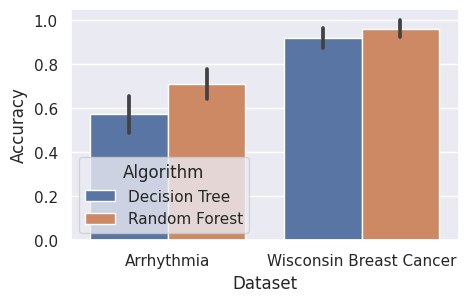

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

sns.barplot(data=result, x=DATASET, y=ACCURACY, hue=ALGORITHM, errorbar="sd")
plt.gcf().set_size_inches((5, 3))
plt.show()

## Conclusion

This post describes one way of leveraging multiprocessing to speed up machine learning experiments. I like about this method that it creates a clear structure in the script: 1) set up the experiment, 2) run the experiment using multiprocessing, 3) obtain the result once every execution has finished. I found this to improve the maintainability and readability of my code. You can check out this [gist](https://gist.github.com/heymarco/0dea6fc8121b8639d8702687a97a8c54) for a minimal working example of what I have shown in this post.

On my Thinkpad P14s with 8 cores and 16 threads, parallel execution speeds up sequential execution by a factor of around 2.5; machines with a greater number of CPU cores will achieve an even higher speedup.

In my upcoming post, I will describe how I log my scientific experiments. Stay tuned!